# EDA: Year, Labels, and Text Length
 
Goal: explore how much **`year`**, **label(s)** (`political`, `domestic`), and simple text-length proxies (token counts) relate to each other.

In [2]:
from pathlib import Path 
import sys 
 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
 
plt.style.use("seaborn-v0_8-whitegrid") 
pd.set_option("display.max_columns", 200) 
pd.set_option("display.width", 120) 
 
 
def find_repo_root(start: Path) -> Path: 
    for path in [start] + list(start.parents): 
        if (path / "data" / "belgium_newspaper_new_filter.csv").exists(): 
            return path 
    raise FileNotFoundError("Could not find repo root containing data/belgium_newspaper_new_filter.csv") 
 
 
REPO_ROOT = find_repo_root(Path.cwd()) 
sys.path.insert(0, str(REPO_ROOT)) 
 
DATA_PATH = REPO_ROOT / "data" / "belgium_newspaper_new_filter.csv" 
DATA_PATH

WindowsPath('d:/Projects/GitRepositories/parizek/NLP-for-Political-Texts-JPM444/data/belgium_newspaper_new_filter.csv')

In [3]:
from scripts.data_processing import load_processing 
 
df = load_processing(DATA_PATH).copy() 
 
df["date_dt"] = pd.to_datetime(df["date"], dayfirst=True, errors="coerce") 
assert df["date_dt"].notna().all(), "Some dates failed to parse" 
df["year"] = df["date_dt"].dt.year.astype(int) 
 
# Simple length proxies 
df["desc_tokens"] = df["description"].fillna("").str.split().str.len().astype(int) 
df["headline_tokens"] = df["headline"].fillna("").str.split().str.len().astype(int) 
df["desc_tokens_log1p"] = np.log1p(df["desc_tokens"]) 
df["headline_tokens_log1p"] = np.log1p(df["headline_tokens"]) 
 
df[["id", "year", "headline", "political", "domestic", "desc_tokens", "headline_tokens"]].head(3)

,id,year,headline,political,domestic,desc_tokens,headline_tokens
0,432916.0,2008,Vlaanderen zwijgt werklozenpremie Milquet dood,1,1,384,5
1,432957.0,2008,Mieke Vogels onder vuur bij Groen!,1,1,426,6
2,432959.0,2008,Slachtoffers Ghislenghien weldra vergoed,1,1,82,4


## Quick Overview

In [4]:
print("shape:", df.shape) 
display(df[["year", "political", "domestic", "desc_tokens", "headline_tokens"]].describe()) 
display(df[["political", "domestic"]].mean().to_frame("positive_rate"))

shape: (19317, 12)


,year,political,domestic,desc_tokens,headline_tokens
count,19317.000000,19317.000000,19317.000000,19317.000000,19317.000000
mean,2004.152974,0.472175,0.722421,283.052337,4.988663
std,2.864339,0.499238,0.447816,160.482295,2.077382
min,1999.000000,0.000000,0.000000,1.000000,0.000000
25%,2002.000000,0.000000,0.000000,137.000000,4.000000
50%,2005.000000,0.000000,1.000000,287.000000,5.000000
75%,2007.000000,1.000000,1.000000,392.000000,6.000000
max,2008.000000,1.000000,1.000000,3495.000000,39.000000


,positive_rate
political,0.472175
domestic,0.722421


## Year vs Labels (rates and volume)

,n,political_rate,domestic_rate,mean_desc_tokens,mean_headline_tokens
year,,,,,
1999,1514,0.448481,0.642008,320.423382,5.848745
2000,1461,0.512663,0.712526,308.917864,5.613963
2001,1542,0.497406,0.735409,286.592088,4.738003
2002,1517,0.437706,0.729730,284.421226,4.186552
2003,1542,0.471466,0.747730,294.686122,4.455901
2004,1652,0.521792,0.742736,335.496368,5.036925
2005,2088,0.486111,0.710249,306.808908,4.892720
2006,2879,0.413338,0.685307,248.723515,4.978465
2007,2763,0.482085,0.764025,244.966341,4.976837


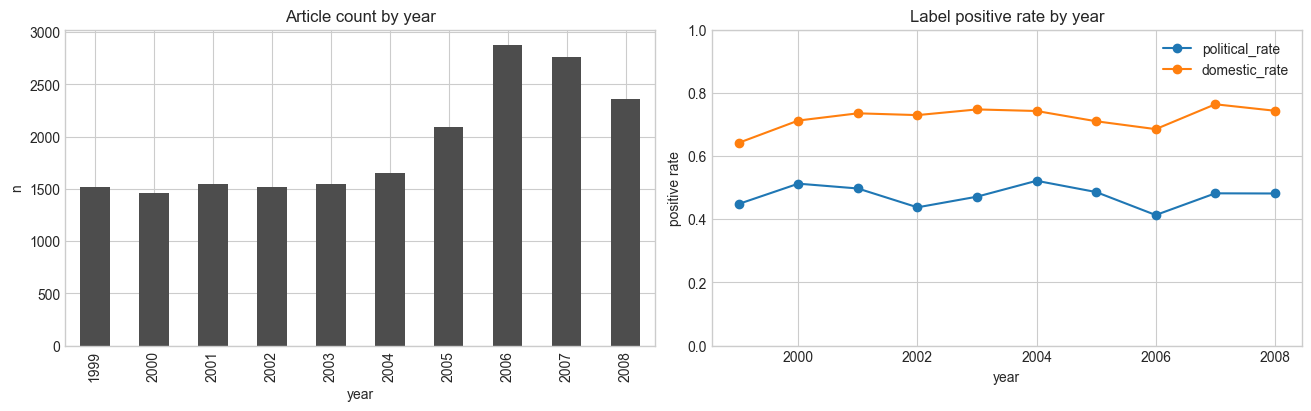

In [5]:
year_stats = df.groupby("year").agg( 
    n=("id", "size"), 
    political_rate=("political", "mean"), 
    domestic_rate=("domestic", "mean"), 
    mean_desc_tokens=("desc_tokens", "mean"), 
    mean_headline_tokens=("headline_tokens", "mean"), 
).sort_index() 
display(year_stats) 
 
fig, axes = plt.subplots(1, 2, figsize=(13, 4), constrained_layout=True) 
 
year_stats["n"].plot(kind="bar", ax=axes[0], color="0.3") 
axes[0].set_title("Article count by year") 
axes[0].set_ylabel("n") 
 
year_stats[["political_rate", "domestic_rate"]].plot(ax=axes[1], marker="o") 
axes[1].set_title("Label positive rate by year") 
axes[1].set_ylabel("positive rate") 
axes[1].set_ylim(0, 1) 
 
plt.show()

## Year vs Token Counts

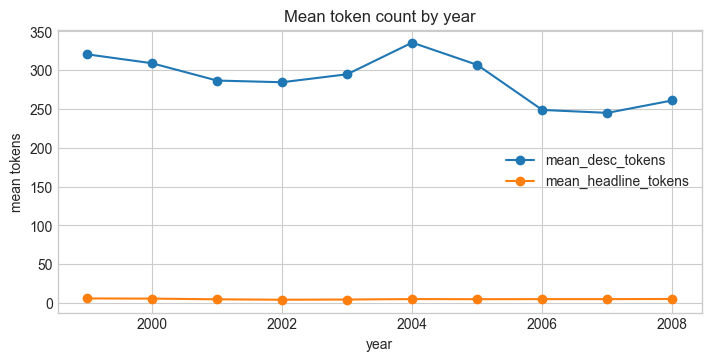

In [6]:
fig, ax = plt.subplots(figsize=(7, 3.5), constrained_layout=True) 
year_stats[["mean_desc_tokens", "mean_headline_tokens"]].plot(ax=ax, marker="o") 
ax.set_title("Mean token count by year") 
ax.set_ylabel("mean tokens") 
plt.show()

## Token Counts vs Labels

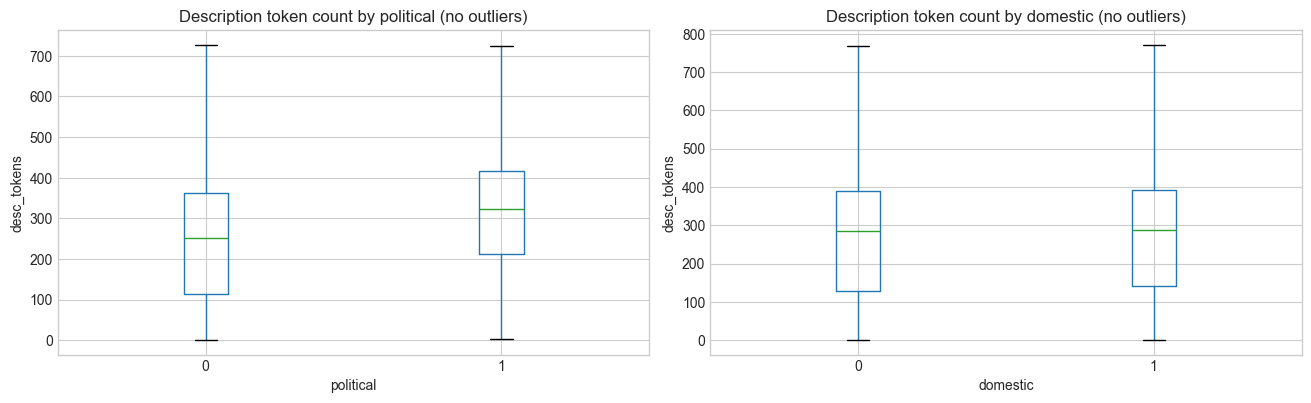

domestic,0,1
political,,
0,0.260887,0.739113
1,0.296239,0.703761


In [7]:
fig, axes = plt.subplots(1, 2, figsize=(13, 4), constrained_layout=True) 
 
df.boxplot(column="desc_tokens", by="political", showfliers=False, ax=axes[0]) 
axes[0].set_title("Description token count by political (no outliers)") 
axes[0].set_xlabel("political") 
axes[0].set_ylabel("desc_tokens") 
 
df.boxplot(column="desc_tokens", by="domestic", showfliers=False, ax=axes[1]) 
axes[1].set_title("Description token count by domestic (no outliers)") 
axes[1].set_xlabel("domestic") 
axes[1].set_ylabel("desc_tokens") 
 
plt.suptitle("") 
plt.show() 
 
pd.crosstab(df["political"], df["domestic"], normalize="index").rename_axis(index="political", columns="domestic")

## Correlations (Pearson)

,year,political,domestic,desc_tokens,headline_tokens
year,1.000000,-0.007504,0.034317,-0.128883,-0.039504
political,-0.007504,1.000000,-0.039412,0.183947,0.096762
domestic,0.034317,-0.039412,1.000000,-0.000006,-0.088472
desc_tokens,-0.128883,0.183947,-0.000006,1.000000,0.223866
headline_tokens,-0.039504,0.096762,-0.088472,0.223866,1.000000


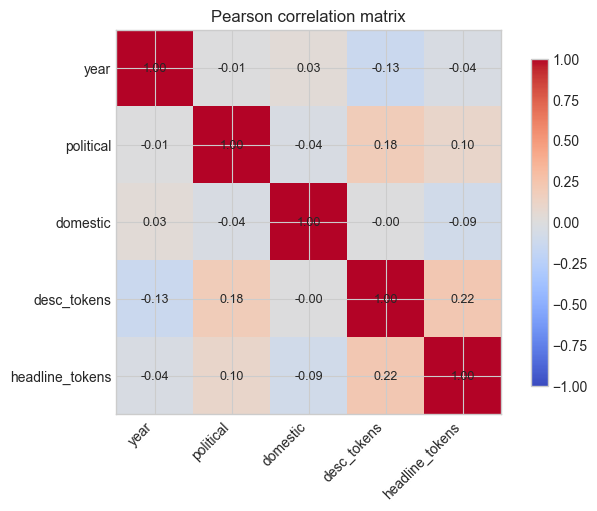

In [8]:
numeric_cols = ["year", "political", "domestic", "desc_tokens", "headline_tokens"] 
corr = df[numeric_cols].corr(numeric_only=True) 
display(corr) 
 
fig, ax = plt.subplots(figsize=(7, 5), constrained_layout=True) 
im = ax.imshow(corr.values, cmap="coolwarm", vmin=-1, vmax=1) 
ax.set_xticks(range(len(corr.columns))) 
ax.set_xticklabels(corr.columns, rotation=45, ha="right") 
ax.set_yticks(range(len(corr.index))) 
ax.set_yticklabels(corr.index) 
for (i, j), v in np.ndenumerate(corr.values): 
    ax.text(j, i, f"{v:.2f}", ha="center", va="center", fontsize=9) 
fig.colorbar(im, ax=ax, shrink=0.85) 
ax.set_title("Pearson correlation matrix") 
plt.show()

In [9]:
from scipy.stats import chi2_contingency, pointbiserialr, spearmanr 
 
tests = [] 
for label in ["political", "domestic"]: 
    for feature in ["year", "desc_tokens", "headline_tokens"]: 
        r_pb, p_pb = pointbiserialr(df[label].astype(int), df[feature].astype(float)) 
        r_sp, p_sp = spearmanr(df[label], df[feature]) 
        tests.append( 
            { 
                "label": label, 
                "feature": feature, 
                "pointbiserial_r": r_pb, 
                "pointbiserial_p": p_pb, 
                "spearman_r": r_sp, 
                "spearman_p": p_sp, 
            } 
        ) 
 
tests_df = pd.DataFrame(tests) 
tests_df["abs_pointbiserial_r"] = tests_df["pointbiserial_r"].abs() 
display(tests_df.sort_values(["label", "abs_pointbiserial_r"], ascending=[True, False])) 
 
# Association between the two binary labels 
ct = pd.crosstab(df["political"], df["domestic"]) 
chi2, p, dof, expected = chi2_contingency(ct) 
phi = np.sign(df["political"].corr(df["domestic"])) * np.sqrt(chi2 / ct.to_numpy().sum()) 
print("political vs domestic:") 
print("  chi2=", round(chi2, 3), "p=", p) 
print("  phi=", round(phi, 4))

,label,feature,pointbiserial_r,pointbiserial_p,spearman_r,spearman_p,abs_pointbiserial_r
5,domestic,headline_tokens,-0.088472,7.094575e-35,-0.097797,2.874274e-42,0.088472
3,domestic,year,0.034317,1.836762e-06,0.033929,2.397335e-06,0.034317
4,domestic,desc_tokens,-0.000006,9.993316e-01,0.008210,2.538681e-01,0.000006
1,political,desc_tokens,0.183947,1.316505e-146,0.214705,3.044486e-200,0.183947
2,political,headline_tokens,0.096762,2.071962e-41,0.085044,2.408226e-32,0.096762
0,political,year,-0.007504,2.969882e-01,-0.007053,3.269529e-01,0.007504


political vs domestic:
  chi2= 29.83 p= 4.717229106794322e-08
  phi= -0.0393


## Simple Predictive Check (How Informative?) 
 
Quick sanity check: can we predict each label using **only** year + token counts (+ the other label as a feature)? 
 
Metric focus: **ROC AUC** and **balanced accuracy** (more stable than F1 when classes are imbalanced).

In [10]:
from sklearn.dummy import DummyClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import StratifiedKFold, cross_validate 
from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import StandardScaler 
 
 
def eval_feature_sets(df: pd.DataFrame, target: str) -> pd.DataFrame: 
    if target not in {"political", "domestic"}: 
        raise ValueError("target must be 'political' or 'domestic'") 
    other = "domestic" if target == "political" else "political" 
 
    feature_sets = { 
        "year": ["year"], 
        "desc_tokens": ["desc_tokens"], 
        "headline_tokens": ["headline_tokens"], 
        "year+tokens": ["year", "desc_tokens", "headline_tokens"], 
        "year+tokens+other_label": ["year", "desc_tokens", "headline_tokens", other], 
    } 
 
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) 
    y = df[target].astype(int) 
 
    rows = [] 
 
    # Baseline 
    baseline = DummyClassifier(strategy="most_frequent") 
    baseline_scores = cross_validate( 
        baseline, 
        df[["year"]], 
        y, 
        cv=cv, 
        scoring={"roc_auc": "roc_auc", "bacc": "balanced_accuracy"}, 
    ) 
    rows.append( 
        { 
            "features": "(baseline) most_frequent", 
            "roc_auc_mean": baseline_scores["test_roc_auc"].mean(), 
            "bacc_mean": baseline_scores["test_bacc"].mean(), 
        } 
    ) 
 
    for name, cols in feature_sets.items(): 
        X = df[cols] 
        model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000)) 
        scores = cross_validate( 
            model, 
            X, 
            y, 
            cv=cv, 
            scoring={"roc_auc": "roc_auc", "bacc": "balanced_accuracy"}, 
        ) 
        rows.append( 
            { 
                "features": name, 
                "roc_auc_mean": scores["test_roc_auc"].mean(), 
                "bacc_mean": scores["test_bacc"].mean(), 
            } 
        ) 
 
    out = pd.DataFrame(rows).sort_values("roc_auc_mean", ascending=False).reset_index(drop=True) 
    return out 
 
 
display(eval_feature_sets(df, target="political")) 
display(eval_feature_sets(df, target="domestic"))

,features,roc_auc_mean,bacc_mean
0,year+tokens+other_label,0.626823,0.586034
1,year+tokens,0.624837,0.585495
2,desc_tokens,0.624156,0.585084
3,headline_tokens,0.548359,0.516013
4,year,0.504023,0.500000
5,(baseline) most_frequent,0.500000,0.500000


,features,roc_auc_mean,bacc_mean
0,year+tokens+other_label,0.573146,0.500117
1,year+tokens,0.569651,0.499988
2,headline_tokens,0.562010,0.500296
3,year,0.521765,0.500000
4,(baseline) most_frequent,0.500000,0.500000
5,desc_tokens,0.485177,0.500000


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19317 entries, 0 to 19318
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     19317 non-null  float64       
 1   description            19317 non-null  object        
 2   date                   19317 non-null  object        
 3   headline               19085 non-null  object        
 4   domestic               19317 non-null  int64         
 5   political              19317 non-null  int64         
 6   date_dt                19317 non-null  datetime64[ns]
 7   year                   19317 non-null  int64         
 8   desc_tokens            19317 non-null  int64         
 9   headline_tokens        19317 non-null  int64         
 10  desc_tokens_log1p      19317 non-null  float64       
 11  headline_tokens_log1p  19317 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(5), object(3)
memory usag

In [16]:
df_1 = pd.read_csv(DATA_PATH)

In [20]:
for col in df_1.columns:
    print(col, df_1[col].isna().sum())


id 11
description 11
date 11
headline 243
domestic 11
political 20
